# Qcodes+broadbean example with Tektronix AWG5208

In [1]:
%matplotlib notebook
from qcodes.instrument_drivers.tektronix.AWG5208 import AWG5208
import broadbean as bb

ramp = bb.PulseAtoms.ramp
sine = bb.PulseAtoms.sine

## Part 1: Make a complicated sequence

Keeping in mind that no waveform can be shorter than 2400 points (hardware limitation).

We have an element corresponding to a measurement that we'd like to repeat N times followed by a "reset" element. The master sequence should then repeat that whole thing with different measurement frequencies. We therefore make the measurement into a subsequence.

<IPython.core.display.Javascript object>


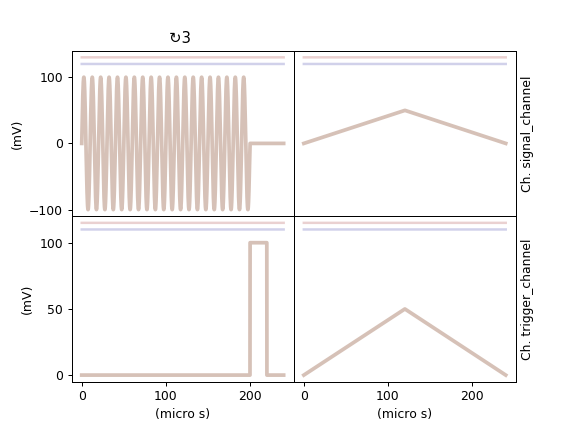

In [2]:
# First we form the measurement sequence

SR = 1e9
N = 3  # the number of times we repeat the first part
measurement_freqs = [5e4, 1e5, 2e5]

meas_bp_ch1 = bb.BluePrint()
meas_bp_ch1.insertSegment(0, sine, (1e5, 0.1, 0, 0), dur=200e-6)
meas_bp_ch1.insertSegment(-1, ramp, (0, 0), dur=40e-6)
meas_bp_ch1.setSR(SR)

meas_bp_ch2 = bb.BluePrint()
meas_bp_ch2.insertSegment(0, ramp, (0, 0), dur=200e-6)
meas_bp_ch2.insertSegment(-1, ramp, (0.1, 0.1), dur=20e-6)
meas_bp_ch2.insertSegment(-1, ramp, (0, 0), dur=20e-6)
meas_bp_ch2.setSR(SR)

meas_elem = bb.Element()
meas_elem.addBluePrint('signal_channel', meas_bp_ch1)
meas_elem.addBluePrint('trigger_channel', meas_bp_ch2)


reset_bp = bb.BluePrint()
reset_bp.insertSegment(0, ramp, (0, 0.05), dur=120e-6)
reset_bp.insertSegment(1, ramp, (0.05, 0), dur=120e-6)
reset_bp.setSR(SR)

reset_elem = bb.Element()
reset_elem.addBluePrint('signal_channel', reset_bp)
reset_elem.addBluePrint('trigger_channel', reset_bp)


measureseq = bb.Sequence()
measureseq.setSR(SR)
measureseq.addElement(1, meas_elem)
measureseq.addElement(2, reset_elem)
measureseq.setSequencingNumberOfRepetitions(1, N)

measureseq.plotSequence()


<IPython.core.display.Javascript object>


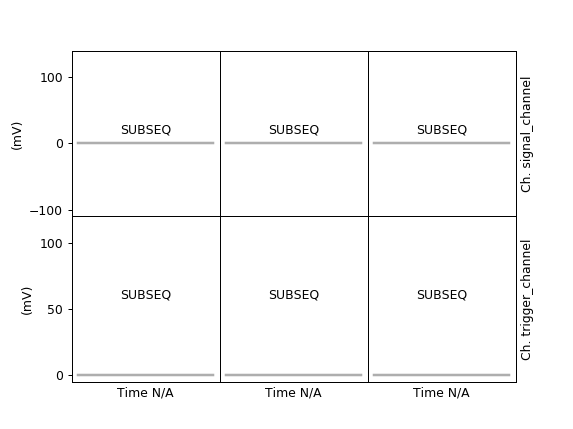

In [3]:
# And then we turn that into a master sequence

mainseq = bb.Sequence()
mainseq.setSR(SR)

for pos, freq in enumerate(measurement_freqs):
    subseq = measureseq.copy()
    subseq.element(1).changeArg('signal_channel', 'sine',
                                'freq', freq)
    mainseq.addSubSequence(pos+1, subseq)

mainseq.plotSequence()

# The visualisation is not terribly helpful in this case, but
# we see that three subsequences are present

## Part 2: Get the sequence onto the instrument

In [4]:
# Connect

awg = AWG5208('awg', 'TCPIP0::192.168.15.118::inst0::INSTR')

Connected to: TEKTRONIX AWG5208 (serial:B020203, firmware:FV:6.0.0242.0) in 0.30s


In [5]:
# forge the sequence
fs = mainseq.forge()

# send it to the instrument
seqname = 'mytestseq'
amplitudes = [ch.awg_amplitude() for ch in awg.channels][:2]
channel_mapping = {'trigger_channel': 2, 'signal_channel': 1}
seqx_file = AWG5208.makeSEQXFileFromForgedSequence(fs,
                                                   amplitudes=amplitudes,
                                                   seqname=seqname,
                                                   channel_mapping=channel_mapping)

# load it and assign its tracks to the channels
filename = 'mainplussub.seqx'

awg.clearSequenceList()
awg.clearWaveformList()
awg.sendSEQXFile(seqx_file, filename=filename)
awg.loadSEQXFile(filename)
awg.ch1.setSequenceTrack(seqname, 1)
awg.ch2.setSequenceTrack(seqname, 2)

# Part 3: Play it and capture it on a scope

Pending... Manually verified.